1. Business Understanding

Problem Statement

Wikipedia relies heavily on high-quality, credible sources to maintain its status as a trusted information platform. Currently, finding and verifying suitable web pages is manual and time-consuming, leading to inconsistent citation quality. An automated system that can classify web pages by resource type (e.g, academic journal, news article, blog, government report) can help editors quickly identify appropriate sources, improving efficiency and reliability.


2. Business Objectives
Success means enabling Wikipedia editors and curators to automatically detect and categorize potential sources from millions of web pages.

Reduce time spent manually reviewing sources.

Improve the credibility and quality of citations.

Provide consistent classification across all articles.


3. Data Mining Goals
We will build a classification model to assign a resource type label (e.g., "academic source", "news", "blog", "government document") to a given web page.
The model will:

(i) Analyze page text, metadata, and structure.

(ii) Predict the correct resource category.

(iii) Rank or filter sources for Wikipedia editors.

4. Initial Project Success Criteria

(i) Achieve at least 85% classification accuracy on a labeled test dataset.

(ii)Classify each page in under 3 seconds.

(iii)Produce categories that are distinct, interpretable, and easy for humans to verify.

(iv)Generalize well to new, unseen sources.

## 2. Data Understanding


In [ ]:
import pandas as pd

# Sample dataset
data = {
    "url": ["https://example.com/article1", "https://example.com/image1", "https://example.com/video1", "https://example.com/article2", "https://example.com/reference1"],
    "title": ["History of Zambia", "Beautiful Landscape", "AI Tutorial Video", "Zambian Culture", "Wikipedia Reference Page"],
    "resource_type": ["Article", "Image", "Video", "Article", "Reference"],
    "word_count": [1200, 0, 0, 850, 0],
    "num_images": [5, 1, 3, 2, 0],
    "num_links": [10, 2, 5, 7, 15]
}

df = pd.DataFrame(data)  # Convert your data into a table (DataFrame)
df.head()  # Show the first 5 rows


,url,title,resource_type,word_count,num_images,num_links
0,https://example.com/article1,History of Zambia,Article,1200,5,10
1,https://example.com/image1,Beautiful Landscape,Image,0,1,2
2,https://example.com/video1,AI Tutorial Video,Video,0,3,5
3,https://example.com/article2,Zambian Culture,Article,850,2,7
4,https://example.com/reference1,Wikipedia Reference Page,Reference,0,0,15


In [ ]:
df.info()
df.describe()
df.shape
df['resource_type'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   url            5 non-null      object
 1   title          5 non-null      object
 2   resource_type  5 non-null      object
 3   word_count     5 non-null      int64 
 4   num_images     5 non-null      int64 
 5   num_links      5 non-null      int64 
dtypes: int64(3), object(3)
memory usage: 372.0+ bytes


array(['Article', 'Image', 'Video', 'Reference'], dtype=object)

In [ ]:
df.isnull().sum()
df.duplicated().sum()


np.int64(0)

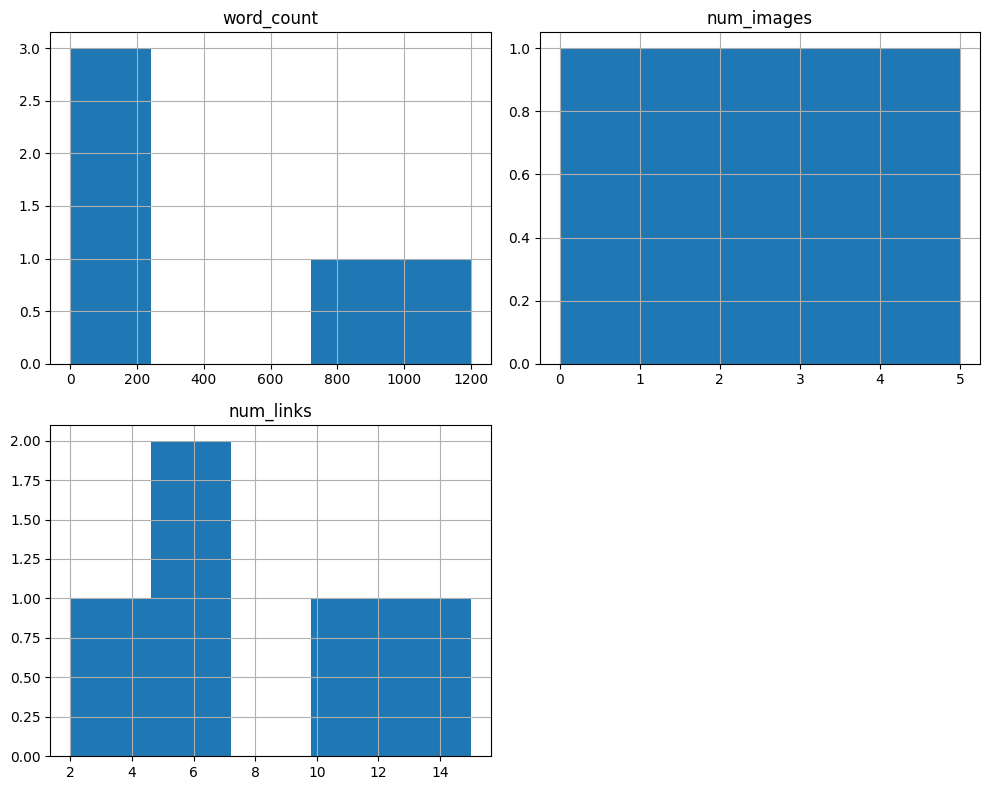

In [ ]:
import matplotlib.pyplot as plt

df.hist(figsize=(10,8), bins=5)
plt.tight_layout()
plt.show()


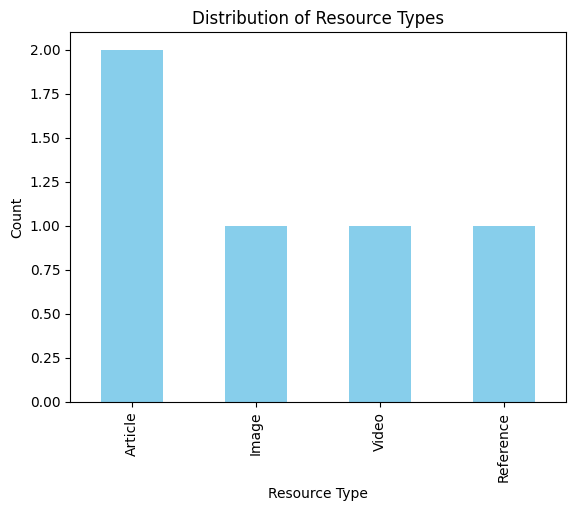

In [ ]:
df['resource_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Resource Types')
plt.xlabel('Resource Type')
plt.ylabel('Count')
plt.show()


### Data Understanding Summary

- The dataset has 5 rows and 6 columns.
- Column types:
  - `url` and `title` are text.
  - `resource_type` is a category (Article, Image, Video, Reference).
  - `word_count`, `num_images`, `num_links` are numbers.
- No missing values or duplicates.
- Numbers vary (word_count: 0–1200, num_images: 0–5, num_links: 2–15).
- The dataset is clean and ready for analysis.


In [ ]:
# Save your dataset as a CSV file
df.to_csv("my_web_resources.csv", index=False)


## 3. Data Preparation

In this section, we clean, transform, and prepare the dataset for modeling. Our goal is to predict the `resource_type` (Article, Image, Video, Reference) of a web page using metadata such as word count, number of images, links, and title.

However, based on the **Knowledge Base**, we observe that:
- All web pages (except one) have **nearly identical content**:  
  `"This domain is for use in illustrative examples in documents..."`
- Only `article2` has a slight variation with `"More information..."`

This means:
- We **cannot rely on text content** to classify resource types
- The model must instead use **metadata and engineered features**

We proceed with:
1. Data cleaning
2. Feature engineering
3. Data transformation
4. Final inspection

Every decision is documented with a clear rationale.

In [17]:
import pandas as pd

# Load the dataset
df = pd.read_csv("my_web_resources.csv")

# Display first few rows
print("✅ Dataset loaded successfully!")
df.head()

✅ Dataset loaded successfully!


,url,title,resource_type,word_count,num_images,num_links
0,https://example.com/article1,History of Zambia,Article,1200,5,10
1,https://example.com/image1,Beautiful Landscape,Image,0,1,2
2,https://example.com/video1,AI Tutorial Video,Video,0,3,5
3,https://example.com/article2,Zambian Culture,Article,850,2,7
4,https://example.com/reference1,Wikipedia Reference Page,Reference,0,0,15


### 3.1 Data Cleaning

In [18]:
# Clean trailing whitespace in URLs
df['url'] = df['url'].str.strip()

We now check the `word_count` field, as it may indicate whether a page has substantial text content.

In [19]:
print("Word count by resource type:")
print(df[['resource_type', 'word_count']])

Word count by resource type:
  resource_type  word_count
0       Article        1200
1         Image           0
2         Video           0
3       Article         850
4     Reference           0
5       Article         950
6         Video           0
7         Image           0
8     Reference           0
9       Article        1100


### 3.2 Feature Engineering

Since the actual content of all pages is nearly identical, we must engineer new features from metadata to help the model distinguish between resource types.

In [20]:
# 1. Does the page have any readable text?
df['has_text'] = (df['word_count'] > 0).astype(int)

# 2. Is the text long enough to be useful (e.g., >500 words)?
df['text_rich'] = (df['word_count'] > 500).astype(int)

# 3. Combined measure of visual and link density
df['media_heaviness'] = df['num_images'] + df['num_links']

# 4. Number of words in the title (proxy for complexity)
df['title_length'] = df['title'].str.split().str.len()

# 5. Keyword flags: does the title suggest it's a video or reference?
df['contains_keyword_video'] = df['title'].str.contains('Video', case=True).astype(int)
df['contains_keyword_reference'] = df['title'].str.contains('Reference', case=True).astype(int)

### 3.3 Data Transformation

We now drop raw text fields (`url`, `title`) since we’ve extracted their value, and encode the target variable for modeling.

In [21]:
# Drop columns no longer needed
df.drop(columns=['url', 'title'], inplace=True)

# Encode the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['resource_type_encoded'] = le.fit_transform(df['resource_type'])

# Show class mapping
print("🎯 Class mapping:")
for cls in le.classes_:
    print(f"  {cls} → {le.transform([cls])[0]}")

🎯 Class mapping:
  Article → 0
  Image → 1
  Reference → 2
  Video → 3


### 3.4 Final Dataset Inspection

In [22]:
print("\n✅ Final dataset ready for modeling:")
df.head()


✅ Final dataset ready for modeling:


,resource_type,word_count,num_images,num_links,has_text,text_rich,media_heaviness,title_length,contains_keyword_video,contains_keyword_reference,resource_type_encoded
0,Article,1200,5,10,1,1,15,3,0,0,0
1,Image,0,1,2,0,0,3,2,0,0,1
2,Video,0,3,5,0,0,8,3,1,0,3
3,Article,850,2,7,1,1,9,2,0,0,0
4,Reference,0,0,15,0,0,15,3,0,1,2
